# Intro

# Libraries

In [52]:
from typing import Tuple

import logging
import os
import gc
import shutil

import mlflow
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pingouin as pg
import scipy.stats as st
from stable_baselines3.ppo import PPO, MlpPolicy
from stable_baselines3.a2c import A2C, MlpPolicy
import scipy.stats as st
import tensorflow.keras as krs
import src.algorithms.algo_utils as autil
import src.algorithms.advantages as adv
import src.algorithms.dummy as dummy
from src.envs.resource_allocation_env import DiscreteProjectsEnv, DiscreteProjectOptimizerAgent
import src.algorithms.policy_gradient.tf2.ppo as ppo
import src.algorithms.policy_gradient.tf2.ac as ac
import src.algorithms.policy_gradient.tf2.vpg as vpg
import src.models.base_models.tf2.policy_nets as policy_nets
import src.models.base_models.tf2.value_nets as vnets
import src.utils as util
from tensorflow_probability.python.distributions import TruncatedNormal
from tqdm.auto import tqdm

import mlflow.tensorflow as mlftf
import mlflow as mlf

In [2]:
from importlib import reload

In [3]:
dummy = reload(dummy)

In [4]:
log = logging.getLogger()
log.setLevel(logging.INFO)
std_handler = logging.StreamHandler(sys.stdout)
log.addHandler(std_handler)

In [ ]:
mlf.autolog()
mlf.tensorflow.autolog()
mlf.keras.autolog()

# Moderate hard env

In [152]:
ENV_SIZE = 300

In [175]:
env_moderate = DiscreteProjectsEnv(
        start_resource=100,
        start_cash=100,
        upkeep_cost=-1,
        min_payout=-0.5,
        max_payout=1.5,
        payout_mean=1.0,
        payout_std=0.5,
        size=ENV_SIZE,
        balance_is_reward=False,
        stochastic=True)

s_dim = env_moderate.observation_space.shape[0]
a_dim = env_moderate.action_space.n

C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))


In [176]:
env_moderate.projects

,proj_1_alloc,proj_1_payouts,proj_1_proba,proj_2_alloc,proj_2_payouts,proj_2_proba
0,50,0.244030,0.510947,91,0.584943,0.707425
1,82,0.686358,0.528155,55,1.132714,0.269939
2,30,0.639138,0.152877,26,0.274723,0.524991
3,54,1.244300,0.470730,35,0.550084,0.472188
4,67,1.202137,0.536334,92,0.552726,0.478150
...,...,...,...,...,...,...
295,5,1.220118,0.139167,6,1.122953,0.584711
296,81,-0.102344,0.144999,60,0.605355,0.896266
297,51,0.692033,0.104889,35,0.781975,0.584273
298,62,1.286093,0.411213,59,0.380066,0.436375


In [177]:
print(env_moderate.reset())

[ 50.           0.24403024   0.51094735  91.           0.58494318
   0.70742524 100.         100.        ]


<AxesSubplot:>

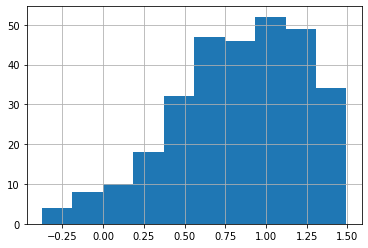

In [8]:
env_moderate.projects.proj_1_payouts.hist()

<AxesSubplot:>

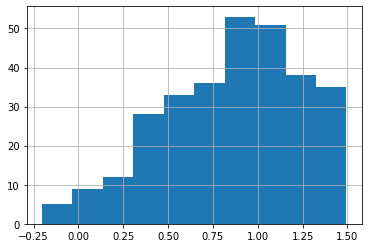

In [9]:
env_moderate.projects.proj_2_payouts.hist()

## Agents

#### PPO

In [22]:
krs.backend.clear_session()
print(gc.collect())

s_dim = env_moderate.observation_space.shape[0]
a_dim = env_moderate.action_space.n

initializer = krs.initializers.HeNormal()
policy_net_ppo = policy_nets.DiscretePolicyNet(a_dim, [128, 128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ppo = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

policy_opt = krs.optimizers.Adam(0.0003)
value_opt = krs.optimizers.Adam(0.0003)

agent_ppo = ppo.PPO(
    policy_net_ppo,
    value_net_ppo,
    policy_opt,
    value_opt,
    adv.GAE,
    n_agents=3,
    clipping_eps=0.2,
    entropy_coef=0.001)

329


#### AC

In [44]:
policy_net_ac = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_ac = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_ac = ac.ActorCrtic(
    policy_net_ac,
    value_net_ac,
    krs.optimizers.Adam(0.0005), #, clipnorm=1.),
    krs.optimizers.Adam(0.0003), #, clipnorm=1.),
    adv.GAE,
    entropy_coef=0.001)

#### VPG

In [55]:
policy_net_vpg = policy_nets.DiscretePolicyNet(a_dim, [128, 128], 'tanh', hidden_initializer=initializer, out_initializer=initializer)
value_net_vpg = vnets.ValueNet(s_dim, [64, 64], h_act='tanh', out_act='linear', initializer=initializer)

agent_vpg = vpg.VPG(
    policy_net_vpg,
    value_net_vpg,
    adv.GAE,
    policy_opt=krs.optimizers.Adam(0.0005), #, clipnorm=1.),
    value_opt=krs.optimizers.Adam(0.0003), #, clipnorm=1.),
    entropy_coef=0.001)

In [12]:
dummy_agent = DiscreteProjectOptimizerAgent(env_moderate)

In [13]:
random_agent = dummy.DummyAgent(env_moderate)

## Evaluate before training

In [24]:
ppo_scores_before = autil.evaluate_algorithm(agent_ppo, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [45]:
ac_scores_before = autil.evaluate_algorithm(agent_ac, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [56]:
vpg_scores_before = autil.evaluate_algorithm(agent_vpg, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [16]:
dummy_scores = autil.evaluate_algorithm(dummy_agent, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [17]:
random_scores = autil.evaluate_algorithm(random_agent, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE, clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

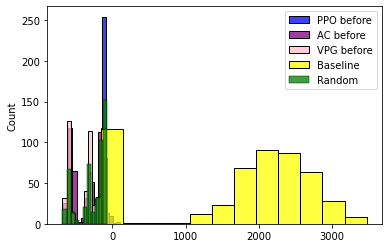

In [57]:
sns.histplot(ppo_scores_before, color='blue', label='PPO before')
sns.histplot(ac_scores_before, color='purple', label='AC before')
sns.histplot(vpg_scores_before, color='pink', label='VPG before')
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(random_scores, color='green', label='Random')
plt.legend()

## Train agent

In [19]:
EXPERIMENT_MODERATE_NAME = 'projects_env_moderate_hard'

In [20]:
experiment_id_moderate = util.prepare_mlflow(EXPERIMENT_MODERATE_NAME)

#### Train PPO

In [57]:
tf_logpath = "./ppo_moderate_projectenv_tensorboard"
if os.path.exists(tf_logpath):
    shutil.rmtree(tf_logpath)
writer = tf.summary.create_file_writer(tf_logpath)

In [26]:
env_moderate.reset()
with mlf.start_run(experiment_id=experiment_id_moderate, run_name='PPO moderate'):
    ppo_scores_after = agent_ppo.train(env_moderate, 600, max_steps=ENV_SIZE, average_n_last=30, print_interval=10, epochs=5, batch_size=64, log=log, gamma=0.99, clip_action=False, max_train_sec=30*60)

Ep: 0/200  Rewards avg.: -194.712  Loss avg.: 0.673  Time passed: 0.009/30.000
Ep: 10/200  Rewards avg.: 486.534  Loss avg.: 0.892  Time passed: 0.587/30.000
Ep: 20/200  Rewards avg.: 923.513  Loss avg.: 0.957  Time passed: 1.580/30.000
Ep: 30/200  Rewards avg.: 1190.082  Loss avg.: 0.966  Time passed: 2.634/30.000
Ep: 40/200  Rewards avg.: 1284.179  Loss avg.: 0.920  Time passed: 3.530/30.000
Ep: 50/200  Rewards avg.: 1035.386  Loss avg.: 0.872  Time passed: 4.304/30.000
Ep: 60/200  Rewards avg.: 730.343  Loss avg.: 1.090  Time passed: 5.241/30.000
Ep: 70/200  Rewards avg.: 933.889  Loss avg.: 0.964  Time passed: 6.233/30.000
Ep: 80/200  Rewards avg.: 1496.744  Loss avg.: 1.107  Time passed: 7.374/30.000
Ep: 90/200  Rewards avg.: 2161.396  Loss avg.: 1.545  Time passed: 8.498/30.000
Ep: 100/200  Rewards avg.: 2424.671  Loss avg.: 0.798  Time passed: 9.464/30.000
Ep: 110/200  Rewards avg.: 2252.174  Loss avg.: 4.955  Time passed: 10.533/30.000
Ep: 120/200  Rewards avg.: 2265.966  Loss 

#### Train AC

In [82]:
tf_logpath = "./ac_moderate_projectenv_tensorboard"
if os.path.exists(tf_logpath):
    shutil.rmtree(tf_logpath)
writer = tf.summary.create_file_writer(tf_logpath)

In [47]:
env_moderate.reset()
with mlf.start_run(experiment_id=experiment_id_moderate, run_name='AC moderate different arch'):
    ac_scores_after = agent_ac.train(
        env_moderate,
        500,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60,
        n_steps=25)

Ep: 0/500  Rewards avg.: -131.000  Loss avg.: 1.127  Time passed: 0.001/15.000
Ep: 10/500  Rewards avg.: -293.325  Loss avg.: 0.852  Time passed: 0.005/15.000
Ep: 20/500  Rewards avg.: -384.028  Loss avg.: 0.509  Time passed: 0.009/15.000
Ep: 30/500  Rewards avg.: -438.109  Loss avg.: 0.568  Time passed: 0.014/15.000
Ep: 40/500  Rewards avg.: -433.589  Loss avg.: 0.527  Time passed: 0.022/15.000
Ep: 50/500  Rewards avg.: -199.200  Loss avg.: 0.850  Time passed: 0.111/15.000
Ep: 60/500  Rewards avg.: 458.515  Loss avg.: 0.974  Time passed: 0.338/15.000
Ep: 70/500  Rewards avg.: 1097.088  Loss avg.: 1.000  Time passed: 0.604/15.000
Ep: 80/500  Rewards avg.: 1591.274  Loss avg.: 1.004  Time passed: 0.844/15.000
Ep: 90/500  Rewards avg.: 1605.128  Loss avg.: 0.996  Time passed: 1.086/15.000
Ep: 100/500  Rewards avg.: 1596.145  Loss avg.: 1.000  Time passed: 1.353/15.000
Ep: 110/500  Rewards avg.: 1588.409  Loss avg.: 1.002  Time passed: 1.616/15.000
Ep: 120/500  Rewards avg.: 1677.100  Los

#### Train VPG

In [58]:
env_moderate.reset()
with mlf.start_run(experiment_id=experiment_id_moderate, run_name='VPG moderate'):
    vpg_scores_after = agent_vpg.train(
        env_moderate,
        500,
        max_steps=ENV_SIZE,
        average_n_last=30,
        print_interval=10,
        log=log,
        gamma=0.99,
        clip_action=False,
        max_train_sec=15*60)

Ep: 0/500  Rewards avg.: nan  Loss avg.: 1.581  Time passed: 0.001/15.000


C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\fwojcik\Anaconda3\envs\py39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Ep: 10/500  Rewards avg.: -205.507  Loss avg.: 0.974  Time passed: 0.008/15.000
Ep: 20/500  Rewards avg.: -190.474  Loss avg.: 0.776  Time passed: 0.017/15.000
Ep: 30/500  Rewards avg.: -173.757  Loss avg.: 0.570  Time passed: 0.038/15.000
Ep: 40/500  Rewards avg.: -136.256  Loss avg.: 0.509  Time passed: 0.072/15.000
Ep: 50/500  Rewards avg.: 212.103  Loss avg.: 0.579  Time passed: 0.277/15.000
Ep: 60/500  Rewards avg.: 764.800  Loss avg.: 0.791  Time passed: 0.487/15.000
Ep: 70/500  Rewards avg.: 1428.966  Loss avg.: 0.862  Time passed: 0.741/15.000
Ep: 80/500  Rewards avg.: 1751.798  Loss avg.: 0.936  Time passed: 0.980/15.000
Ep: 90/500  Rewards avg.: 1756.338  Loss avg.: 0.971  Time passed: 1.179/15.000
Ep: 100/500  Rewards avg.: 1779.767  Loss avg.: 0.977  Time passed: 1.416/15.000
Ep: 110/500  Rewards avg.: 1729.497  Loss avg.: 0.974  Time passed: 1.660/15.000
Ep: 120/500  Rewards avg.: 1767.870  Loss avg.: 0.978  Time passed: 1.877/15.000
Ep: 130/500  Rewards avg.: 1550.157  Lo

## Eval after train

In [28]:
results_dir = "discrete_env_results_moderate"

In [29]:
if os.path.exists(results_dir):
    shutil.rmtree(results_dir)
    os.mkdir(results_dir)

## Compare results

In [30]:
ppo_eval_scores_after = autil.evaluate_algorithm(agent_ppo, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                     clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [48]:
ac_eval_scores_after_500 =  autil.evaluate_algorithm(agent_ac, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                     clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [59]:
vpg_eval_scores_after_500 =  autil.evaluate_algorithm(agent_vpg, env_moderate, n_episodes=500, max_ep_steps=ENV_SIZE,
                                                     clip_action=False)

  0%|          | 0/500 [00:00<?, ?it/s]

In [68]:
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

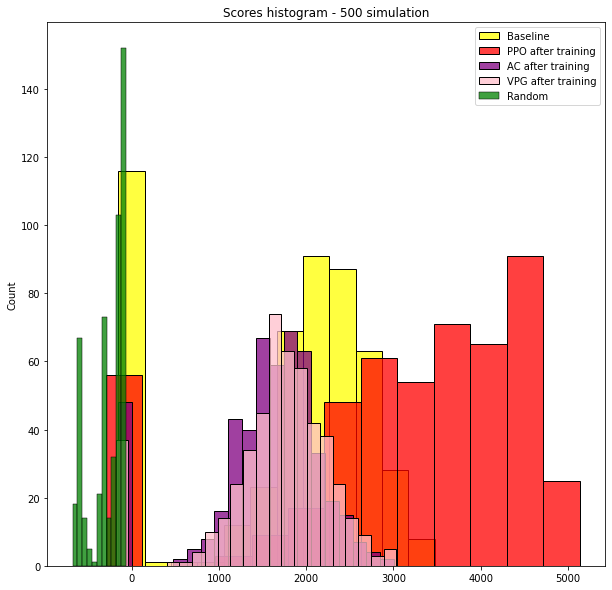

In [88]:
plt.figure(figsize=(10, 10))
sns.histplot(dummy_scores, color='yellow', label='Baseline')
sns.histplot(ppo_eval_scores_after, color='red', label='PPO after training')
sns.histplot(ac_eval_scores_after_500, color='purple', label='AC after training')
sns.histplot(vpg_eval_scores_after_500, color='pink', label='VPG after training')
sns.histplot(random_scores, color='green', label='Random')
plt.title("Scores histogram - 500 simulation")
plt.legend()
plt.savefig(f"./{results_dir}/scores_histogram.png")

In [105]:
result_df = pd.DataFrame({
    #'PPO before': ppo_scores_before,
    #'AC before': ac_scores_before,
    #'VPG before': vpg_scores_before,
    'random': random_scores,
    'PPO after': ppo_eval_scores_after,
    'AC after': ac_eval_scores_after_500,
    'VPG after': vpg_eval_scores_after_500,
    'baseline': dummy_scores, })
result_df.describe()

,random,PPO after,AC after,VPG after,baseline
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,-266.278699,3145.002002,1524.030003,1649.710533,1696.866226
std,187.548901,1426.585874,668.603399,653.539123,1081.587382
min,-679.081834,-300.000000,-160.475944,-186.000527,-152.919976
25%,-352.753367,2583.208931,1293.544828,1424.717208,1262.928403
50%,-171.602811,3471.829401,1640.094288,1721.975024,2050.941616
75%,-112.154216,4247.227386,1941.225954,2032.349058,2474.496026
max,-65.680510,5137.743008,3007.204907,3033.989365,3472.509295


In [71]:
result_df.to_csv(os.path.join(results_dir, "scores_moderate_env.csv"), index=False)

In [106]:
stat, pval = st.levene(*[result_df[c] for c in result_df.columns])
pval.round(4)

0.0

In [126]:
st.shapiro(result_df['VPG after'])

ShapiroResult(statistic=0.8906074166297913, pvalue=2.2188356857619887e-18)

In [108]:
st.shapiro(result_df['VPG after'].loc[result_df['VPG after'] > 500])

ShapiroResult(statistic=0.9959970116615295, pvalue=0.2937912940979004)

In [109]:
melted_df = result_df.melt(var_name='model')
result = pg.welch_anova(melted_df, dv='value', between='model')
result

,Source,ddof1,ddof2,F,p-unc,np2
0,model,4,1080.512772,2581.866768,0.0,0.588618


In [115]:
melted_df.columns

Index(['model', 'value'], dtype='object')

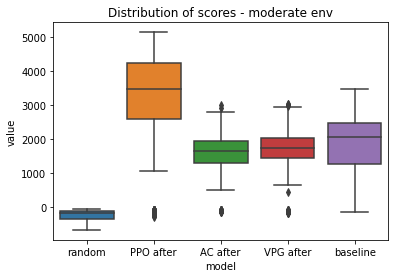

In [118]:
sns.boxplot(data=melted_df, x='model', y='value')
plt.title("Distribution of scores - moderate env");

Text(0.5, 1.0, 'Algorithm scores density - moderate env')

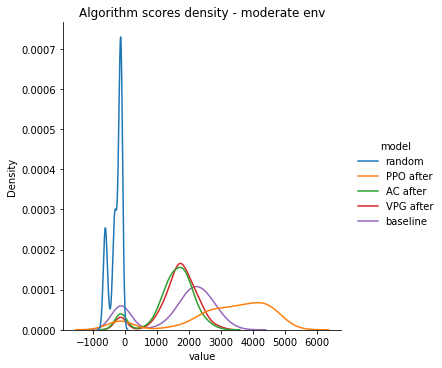

In [140]:
sns.displot(data=melted_df, x='value', hue='model', kind='kde')
plt.title("Algorithm scores density - moderate env")

In [110]:
pairwise_test = pg.pairwise_gameshowell(melted_df, dv='value', between='model', effsize='cohen')
pairwise_test

,A,B,mean(A),mean(B),diff,se,T,df,pval,cohen
0,AC after,PPO after,1524.030003,3145.002002,-1620.971999,70.458183,-23.006157,708.125825,0.001000,-1.455037
1,AC after,VPG after,1524.030003,1649.710533,-125.680529,41.812531,-3.005810,997.482164,0.022731,-0.190104
2,AC after,baseline,1524.030003,1696.866226,-172.836223,56.865838,-3.039368,831.774701,0.020604,-0.192227
3,AC after,random,1524.030003,-266.278699,1790.308702,31.054954,57.649697,577.044420,0.001000,3.646087
4,PPO after,VPG after,3145.002002,1649.710533,1495.291470,70.174933,21.308057,699.612850,0.001000,1.347640
5,PPO after,baseline,3145.002002,1696.866226,1448.135776,80.062207,18.087632,930.193328,0.001000,1.143962
6,PPO after,random,3145.002002,-266.278699,3411.280701,64.347834,53.013140,516.243842,0.001000,3.352845
7,VPG after,baseline,1649.710533,1696.866226,-47.155693,56.514505,-0.834400,820.517385,0.900000,-0.052772
8,VPG after,random,1649.710533,-266.278699,1915.989232,30.406841,63.011783,580.635841,0.001000,3.985215
9,baseline,random,1696.866226,-266.278699,1963.144925,49.091870,39.989206,528.980847,0.001000,2.529139


In [89]:
pairwise_test.to_csv(os.path.join(results_dir, "pairwise_test_res_moderate_env.csv"), index=False)